# Calculating a glacier geodetic mass balance with xdem

### This notebook showcases how to use xdem to calculate the glacier geodetic mass balance of Mera glacier, Nepal, using two DEMs derived from Pleiades stereo images.



### Import the necessary modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import geoutils as gu
import xdem

# To avoid interpolation in plt.imshow
plt.rcParams['image.interpolation'] = 'none'

## 1 - Load input data

All the data is taken from the Mera mass balance tutorial to be presented by Fanny on Thursday. They are already downloaded in the data folder.\
There are 2 Pleiades DEMs from November 2012 and October 2018 that are used to calculate the mass balance. They are at 4 m resolution.\
The 3rd DEM is used to calculate the glacier hypsometry, since it is gap-free. It is extracted from the Copernicus Global DEM at 30 m resolution.\
There are also manual outlines of Mera glacier for the same dates.

#### Get input data path ###

In [2]:
fn_dem_2012 = "./data/mb_Mera/2012-11-25_DEM_4m.tif"
fn_dem_2018 = "./data/mb_Mera/2018-10-28_DEM_4m.tif"
fn_ref_dem = "./data/mb_Mera/Mera_Co30_DEM_UTM45.tif"
rgi_shpfile = "./data/mb_Mera/shapefile_RGI/Glacier_inventory_around_Mera.shp"
mera_shpfile_2012 = "./data/mb_Mera/shapefiles/Mera_outline_2012_realigned.shp"
mera_shpfile_2018 = "./data/mb_Mera/shapefiles/Mera_outline_2018_realigned.shp"

#### Load all DEMs

In [3]:
dem_2012 = xdem.DEM(fn_dem_2012)
dem_2018 = xdem.DEM(fn_dem_2018)
ref_dem = xdem.DEM(fn_ref_dem)

#### Crop and reproject DEMs on a same projection/grid
The intersection of all DEMs is calculated, and then DEMs are projected onto the 2018 DEM grid.\
Note: DEMs are downsampled to 8 m resolution, to reduce memory usage on Binder (limit 2 GB)

In [4]:
bounds = gu.projtools.merge_bounds([dem_2012, dem_2018, ref_dem], merging_algorithm="intersection")
bounds = {"left": bounds[0], "bottom": bounds[1], "right": bounds[2], "top": bounds[3]}
dem_2018 = dem_2018.reproject(dst_bounds=bounds, dst_res=8)
dem_2012 = dem_2012.reproject(dst_ref=dem_2018)
ref_dem = ref_dem.reproject(dst_ref=dem_2018)

#### Load glacier outlines

In [5]:
rgi_outlines = gu.Vector(rgi_shpfile)
mera_outlines_2012 = gu.Vector(mera_shpfile_2012)
mera_outlines_2018 = gu.Vector(mera_shpfile_2018)

### Calculate and plot elevation change

In [6]:
dh = dem_2018 - dem_2012

#### Plot original dh map with glacier contours

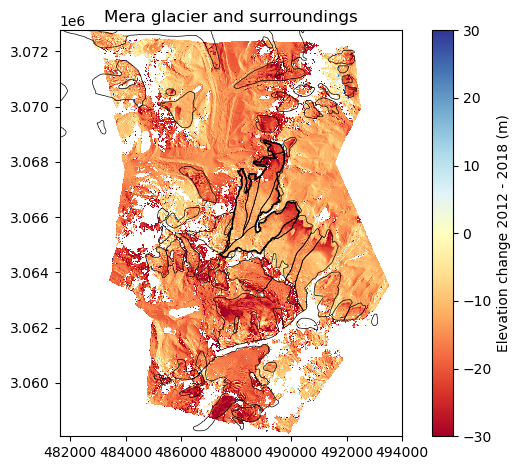

In [7]:
vmax=30
ax = plt.subplot(111)
rgi_outlines.ds.plot(ax=ax, facecolor='none', edgecolor='k', lw=0.5, zorder=2)
mera_outlines_2012.ds.plot(ax=ax, facecolor='none', edgecolor='k', zorder=3)
dh.show(ax=ax, cmap='RdYlBu', vmin=-vmax, vmax=vmax, cb_title='Elevation change 2012 - 2018 (m)', zorder=1)
ax.set_title('Mera glacier and surroundings')
plt.tight_layout()

There are non-zeros elevation changes outside of glaciers => These DEMs need to be coregistered.

## 2 - DEM coregistration

#### Prepare inputs for coregistration
First we create a mask, i.e. a raster of same shape as our dh map, to mask pixels on glaciers. `gl_mask` is `True` on glaciers, `False` elsewhere.

In [8]:
gl_mask = rgi_outlines.create_mask(dh)

Then we mask pixels in steep slopes and gross blunders

In [9]:
slope = xdem.terrain.slope(ref_dem)
slope_mask = (slope.data < 40).filled(False)
outlier_mask = (np.abs(dh.data) < 50).filled(False)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


We plot the final mask of pixels used for coregistration

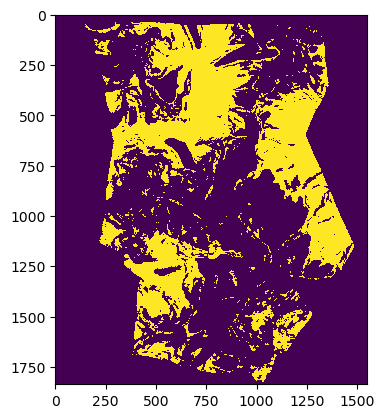

In [10]:
inlier_mask = ~gl_mask & slope_mask & outlier_mask
plt.imshow(inlier_mask.squeeze())

Free memory

In [11]:
del slope, slope_mask, outlier_mask

#### Run coregistration
We use the Nuth & Kaab (2011) algorithm to estimate a horizontal offset, then we remove a possible vertical bias by removing the median dh value in stable terrain.

First, we need to define the coregistration function. \
Then we estimate the coregistration needed between our two Pleiades DEMs. \
Finally, we apply that coregistration to the 2012 DEM.

In [12]:
coreg = xdem.coreg.NuthKaab() + xdem.coreg.BiasCorr(bias_func=np.median)
coreg.fit(dem_2018, dem_2012, inlier_mask, verbose=True)
dem_2012_coreg = coreg.apply(dem_2012)

Running pipeline step: 1 / 2
Running Nuth and Kääb (2011) coregistration
   Calculate slope and aspect
   Statistics on initial dh:
      Median = -13.55 - NMAD = 4.44
   Iteratively estimating horizontal shit:


   Progress:  10%|███████████████████████████████▎                                                                                                                                                                                                                                                                                         | 1/10 [00:00<00:02,  3.38it/s]

      #1 - Offset in pixels : (-1.07, -0.44)
      Median = -13.74 - NMAD = 0.65  ==>  Gain = -85.29%


   Progress:  20%|██████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 2/10 [00:00<00:02,  3.58it/s]

      #2 - Offset in pixels : (-0.04, 0.04)
      Median = -13.80 - NMAD = 0.65  ==>  Gain = -0.54%


   Progress:  20%|██████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 2/10 [00:00<00:03,  2.32it/s]


      #3 - Offset in pixels : (0.00, 0.00)
      Median = -13.79 - NMAD = 0.65  ==>  Gain = -0.00%
   Last offset was below the residual offset threshold of 0.05 -> stopping

   Final offset in pixels (east, north) : (-1.102060, -0.397113)
   Statistics on coregistered dh:
      Median = -13.79 - NMAD = 0.65
Running pipeline step: 2 / 2
Estimating bias...
Bias estimated


The results of the coregistration can be output like this

In [13]:
print(coreg.pipeline[0]._meta)

{'offset_east_px': -1.102059893627442, 'offset_north_px': -0.3971130774218492, 'bias': -13.794286100495356, 'resolution': 8.0}


#### Calculate new elevation change and plot

In [14]:
dh_coreg = dem_2018 - dem_2012_coreg

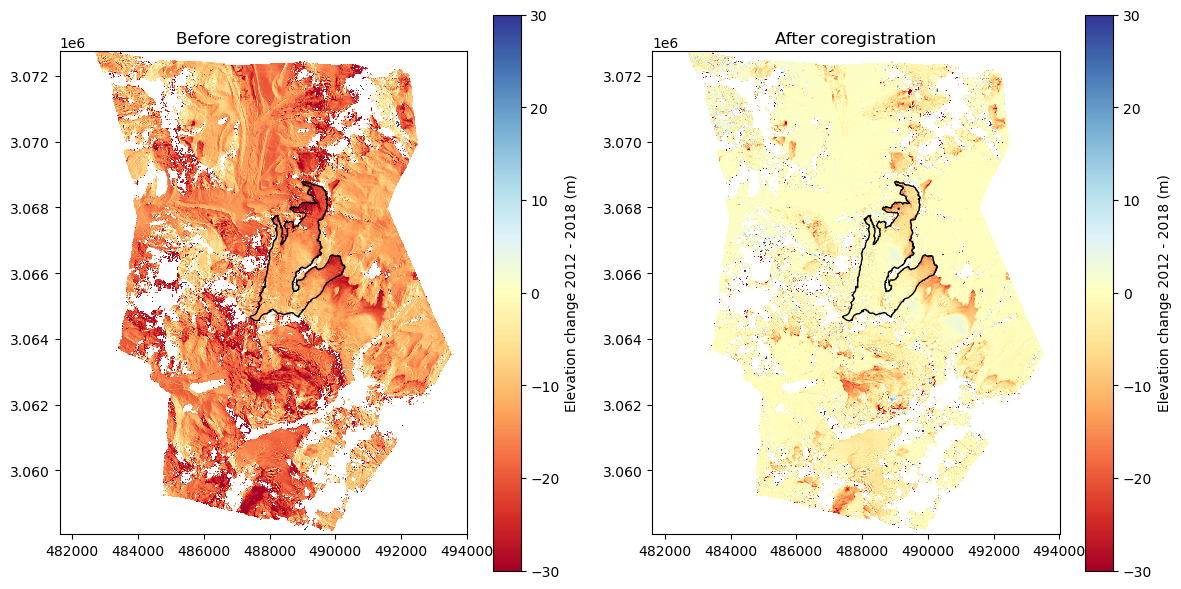

In [15]:
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
mera_outlines_2012.ds.plot(ax=ax1, facecolor='none', edgecolor='k', zorder=3)
dh.show(ax=ax1, cmap='RdYlBu', vmin=-vmax, vmax=vmax, cb_title='Elevation change 2012 - 2018 (m)', zorder=1)
ax1.set_title('Before coregistration')

ax2 = plt.subplot(122)
mera_outlines_2012.ds.plot(ax=ax2, facecolor='none', edgecolor='k', zorder=3)
dh_coreg.show(ax=ax2, cmap='RdYlBu', vmin=-vmax, vmax=vmax, cb_title='Elevation change 2012 - 2018 (m)', zorder=1)
ax2.set_title('After coregistration')

plt.tight_layout()

We see that elevation changes outside glaciers are close to zero (yellow color).

#### Calculate statistics of before/after coregistration
Because `dh.data` is a masked array, we use `compressed()` to output only unmasked values.

In [16]:
inlier_orig = dh.data[inlier_mask].compressed()
nstable_orig, mean_orig = len(inlier_orig), np.mean(inlier_orig)
med_orig, nmad_orig = np.median(inlier_orig), xdem.spatialstats.nmad(inlier_orig)
print(f"Number of stable pixels: {nstable_orig}")
print(f"Before coregistration:\
      \n\tMean dh: {mean_orig:.2f}\
      \n\tMedian dh: {med_orig:.2f}\
      \n\tNMAD dh: {nmad_orig:.2f}")

inlier_coreg = dh_coreg.data[inlier_mask].compressed()
nstable_coreg, mean_coreg = len(inlier_coreg), np.mean(inlier_coreg)
med_coreg, nmad_coreg = np.median(inlier_coreg), xdem.spatialstats.nmad(inlier_coreg)
print(f"After coregistration:\
      \n\tMean dh: {mean_coreg:.2f}\
      \n\tMedian dh: {med_coreg:.2f}\
      \n\tNMAD dh: {nmad_coreg:.2f}")

Number of stable pixels: 668784
Before coregistration:      
	Mean dh: -13.67      
	Median dh: -13.55      
	NMAD dh: 4.44
After coregistration:      
	Mean dh: -0.28      
	Median dh: -0.01      
	NMAD dh: 0.69


## 3 - Geodetic mass balance of Mera glacier

### Calculate mean dh over glaciers, per elevation bins
The calculation requires a (raster) mask of the glacier, the dh values, and a reference DEM used to get the elevation of the pixels. All must be on the same grid. \
The default elevation bins have a height of 50 m, from the DEM minimum to maximum. Here we set the bin height to 25 m with the argument `bins`.

In [17]:
mera_mask = mera_outlines_2012.create_mask(dh_coreg)
ddem_bins = xdem.volume.hypsometric_binning(dh_coreg.data[mera_mask], ref_dem.data[mera_mask], bins=25, aggregation_function=np.median)

The output is a panda's DataFrame containing the elevation bin edges, the mean dh ('value') and observations (valid pixels) count.

In [18]:
print(ddem_bins)

                                          value   count
(4948.51904296875, 4973.51904296875]  -3.608887    49.0
(4973.51904296875, 4998.51904296875] -13.415527    71.0
(4998.51904296875, 5023.51904296875] -13.687988   149.0
(5023.51904296875, 5048.51904296875] -10.561523   219.0
(5048.51904296875, 5073.51904296875]  -7.944824   255.0
(5073.51904296875, 5098.51904296875] -10.437012   387.0
(5098.51904296875, 5123.51904296875] -12.028320   416.0
(5123.51904296875, 5148.51904296875] -10.658691   351.0
(5148.51904296875, 5173.51904296875]  -9.123535   280.0
(5173.51904296875, 5198.51904296875] -10.202637   267.0
(5198.51904296875, 5223.51904296875] -10.160400   262.0
(5223.51904296875, 5248.51904296875]  -8.806152   351.0
(5248.51904296875, 5273.51904296875]  -8.504883   808.0
(5273.51904296875, 5298.51904296875] -11.037598  1712.0
(5298.51904296875, 5323.51904296875] -10.671631  1860.0
(5323.51904296875, 5348.51904296875]  -8.895020  2471.0
(5348.51904296875, 5373.51904296875]  -7.012207 

### Calculate the glacier area within each elevation bin
This is particularly needed for data with gaps, as the values in `ddem_bins['count']` are the number of pixels with observations, not total pixel count.
The result is in m$^2$.

In [19]:
bins_area = xdem.volume.calculate_hypsometry_area(ddem_bins, ref_dem.data[mera_mask], pixel_size=dh_coreg.res)
print(bins_area)

(4948.51904296875, 4973.51904296875]      3136.0
(4973.51904296875, 4998.51904296875]      4864.0
(4998.51904296875, 5023.51904296875]      9856.0
(5023.51904296875, 5048.51904296875]     14016.0
(5048.51904296875, 5073.51904296875]     16384.0
(5073.51904296875, 5098.51904296875]     25152.0
(5098.51904296875, 5123.51904296875]     26624.0
(5123.51904296875, 5148.51904296875]     22592.0
(5148.51904296875, 5173.51904296875]     18816.0
(5173.51904296875, 5198.51904296875]     18240.0
(5198.51904296875, 5223.51904296875]     17792.0
(5223.51904296875, 5248.51904296875]     24000.0
(5248.51904296875, 5273.51904296875]     51840.0
(5273.51904296875, 5298.51904296875]    110912.0
(5298.51904296875, 5323.51904296875]    120448.0
(5323.51904296875, 5348.51904296875]    161408.0
(5348.51904296875, 5373.51904296875]    262336.0
(5373.51904296875, 5398.51904296875]    283264.0
(5398.51904296875, 5423.51904296875]    150912.0
(5423.51904296875, 5448.51904296875]    120448.0
(5448.51904296875, 5

### Plot the results
1. Plot glacier area vs elevation
2. Plot the elevation change vs elevation

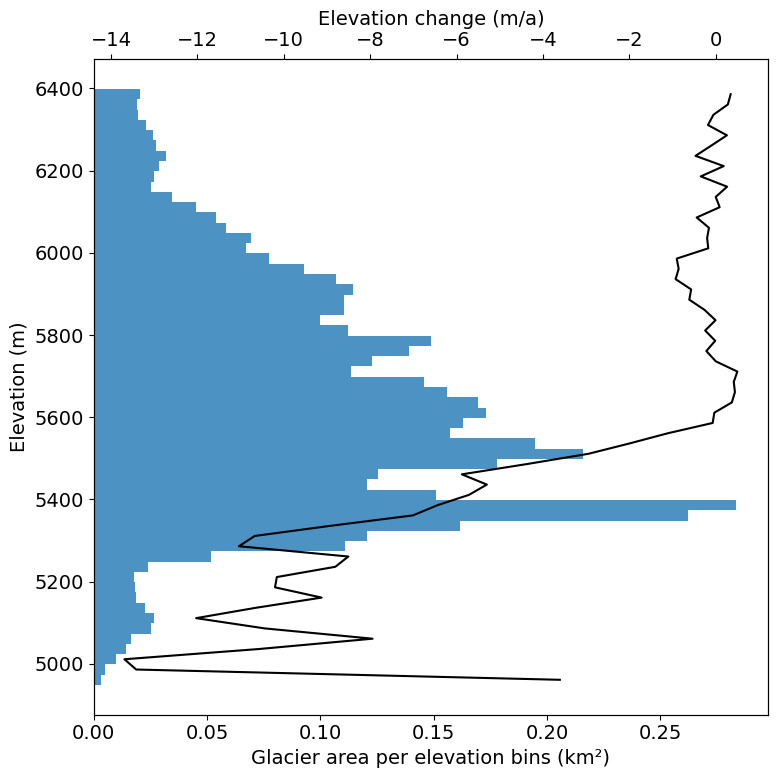

In [20]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=(8, 8))

plt.barh(
    y=ddem_bins.index.mid,
    width=bins_area/1e6,
    left=0,
    height=(ddem_bins.index.left - ddem_bins.index.right) * 1,
    alpha=0.8,
)
plt.xlabel("Glacier area per elevation bins (km\u00b2)")
plt.ylabel("Elevation (m)")

plt.twiny()
plt.plot(ddem_bins["value"], ddem_bins.index.mid, "k")
plt.xlabel("Elevation change (m/a)")

plt.tight_layout()

### Calculate total volume and mass change
- volume change is in m$^3$
- volume is converted to mass (kg) assuming a volume to mass conversion factor of 850 kg/m$^3$ (Huss, 2013, TC)

In [21]:
dV = np.sum(ddem_bins['value'] * bins_area)  # in m^3
dM = 0.85 * dV  # in kg

### Calculate specific mass balance
In meter water equivalent (m w.e.)
We divide by the average area between the two dates.

In [22]:
mean_area = float((mera_outlines_2012.ds.Area + mera_outlines_2018.ds.Area) / 2)
dh_mwe = dM / mean_area

### Print results

In [23]:
print(f"Total volume change: {dV:.2f} m\u00b3")
print(f"Total mass change: {dM/1e3:.2f} t")
print(f"Specific mass balance: {dh_mwe:.1f} m w.e.")

Total volume change: -14620988.02 m³
Total mass change: -12427.84 t
Specific mass balance: -2.5 m w.e.


## It's your turn !

Test running the code with other parameters, here are some ideas:
1. Calculate the mass balance using the mean value of each bin instead of the median.
2. Try with different elevation bin sizes
3. Try removing pixels whose value differ by more than five NMAD from the mean\
How sensitive are your results to these different parameters?\
Can your reproduce the results of Wagnon et al. (2021), JoG. Check the methods to see what bin size and filtering method they used. Your results should match their +/- 0.03 m w.e..
4. Try calculating the mass balance for another glacier.\
Hint 1: To select one glacier from the RGI outlines, use `rgi_outlines.ds[rgi_outlines.ds.RGIId == "YOUR_RGI_ID"]` where YOUR_RGI_ID is replaced by the ID of your chosen glacier, within the Pleiades DEM bounds.